In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

In [2]:
# download data
train = pd.read_csv('train_kaggle.csv')
test = pd.read_csv('test_kaggle.csv')
train['Date'] = pd.to_datetime(train['Date'], dayfirst = True)
test['Date'] = pd.to_datetime(test['Date'], dayfirst = True)
train.set_index(['Date'], inplace=True)
test.set_index(['Date'], inplace=True)

In [3]:
train['Promo'] = train['Promo'].fillna(0)
train.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
train['Regular_Price'] = train['Regular_Price'].ffill().bfill()
train.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

train['Actual_Price'] = train.Promo_Price.combine_first(train.Regular_Price) 
train.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2015-01-01,1,1,0.0,22,163.78,NaN,163.78
2015-01-02,1,1,0.0,41,163.78,NaN,163.78
2015-01-03,1,1,0.0,35,163.78,NaN,163.78
2015-01-04,1,1,0.0,72,163.78,NaN,163.78
2015-01-05,1,1,0.0,25,163.78,NaN,163.78


In [4]:
test['Promo'] = test['Promo'].fillna(0)
test.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
test['Regular_Price'] = test['Regular_Price'].ffill().bfill()
test.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

test['Actual_Price'] = test.Promo_Price.combine_first(test.Regular_Price) 
test.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2016-05-23,1,1,1.0,NaN,128.98,119.6,119.60
2016-05-24,1,1,0.0,NaN,128.98,NaN,128.98
2016-05-25,1,1,0.0,NaN,131.70,NaN,131.70
2016-05-26,1,1,0.0,NaN,131.70,NaN,131.70
2016-05-27,1,1,0.0,NaN,131.70,NaN,131.70


In [5]:
train.reset_index(inplace=True)
train["weekday"] = train.Date.dt.weekday
train["monthday"] = train.Date.dt.day
train['is_weekend'] = train.weekday.isin([5, 6]) * 1

test.reset_index(inplace=True)
test["weekday"] = test.Date.dt.weekday
test["monthday"] = test.Date.dt.day
test['is_weekend'] = test.weekday.isin([5, 6]) * 1

In [6]:
data = pd.concat([train, test]).set_index('Date').reset_index()
data.head()

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1,0.0,22.0,163.78,NaN,163.78,3,1,0
1,2015-01-02,1,1,0.0,41.0,163.78,NaN,163.78,4,2,0
2,2015-01-03,1,1,0.0,35.0,163.78,NaN,163.78,5,3,1
3,2015-01-04,1,1,0.0,72.0,163.78,NaN,163.78,6,4,1
4,2015-01-05,1,1,0.0,25.0,163.78,NaN,163.78,0,5,0


# DYNAMIC + STATIC

In [7]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'perc%s' % n
    return percentile_


def lagged_features(data,
                    target_vars = ['Demand'],
                    id_columns = ['SKU_id'],
                    lags = [7, 14, 21, 28],
                    windows = [1, 2, 3, 4],
                    preaggreagation_methods = ['mean'], # ['mean', 'count']
                    aggregation_methods = ['mean', 'median', percentile(10),  percentile(90)],
                    dynamic_filters = ['weekday'],
                    static_filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_vars - column names which are used to calculate lagged features
        by_store - whether calculate stats by stores or not
        id_columns - columns to groups
        lags - 
        windows - list of windows(string type), calculation is performed within time range length of window
        preaggreagation_methods - applied methods before rolling
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    
    out_df = deepcopy(data)
    df = deepcopy(data)
    
    ## STATIC
    
    true_demand = df['Demand']

    if static_filters is None:
        static_filters = {'':{''}}
    
    ## total number of filters
    total = 0
    for x in flts:
        total += len(flts[x].items())
    
    progress = IntProgress(min=0, max=total)
    display(progress)
    
    for col_name in static_filters:
        for name, f in static_filters[col_name].items():
            condition = col_name + f
            if len(condition) > 0:
                idx = df.eval(condition)
            else:
                idx = df.index >= 0
        
            if len(df[idx].index) > 0:
                df.loc[~idx, 'Demand'] = np.nan
                for w in windows:
                    
                    if w.isdigit():
                        w_ewm = int(w)
                        w_rolling = w + 'D'
                    
                    for preaggr in preaggreagation_methods:
                        for method in aggregation_methods:
                            if method == 'mean':
                                lf_df_ewm = data.set_index('Date').sort_index().groupby(id_columns + ['Date']).agg(preaggr)[target_vars].groupby(id_columns).\
                                    apply(lambda x : x.ewm(span=w_ewm, min_periods=1).agg(method))
#                                 lf_df_ewm = df.set_index('Date').sort_index().groupby(id_columns + ['Date']).\
#                                     agg(preaggr).ewm(span=w * 7, min_periods=1).agg(method)
                            
                            
#                             lf_df_rolling = df.set_index('Date').sort_index().groupby(id_columns + ['Date']).\
#                                 agg(preaggr).rolling(window=w * 7, min_periods=1).agg(method)
            
                            lf_df_rolling = data.set_index('Date').sort_index().groupby(id_columns + ['Date']).agg(preaggr)[target_vars].groupby(id_columns).\
                                apply(lambda x : x.reset_index().set_index('Date').rolling(w_rolling, min_periods=1).agg(method))

                            for l in lags:
                                method_name = method.__name__ if type(method) != str else method
                                
                                new_names_ewm = {x: "{0}_lag{1}d_w{2}d_key{3}_preag{4}_ag{5}_{6}_static_ewm".
                                             format(x, l, w, '_'.join(id_columns), preaggr, method_name, name) for x in lf_df_ewm.columns}
                                
                                new_names_rolling = {x: "{0}_lag{1}d_w{2}d_key{3}_preag{4}_ag{5}_{6}_static_rolling".
                                             format(x, l, w, '_'.join(id_columns), preaggr, method_name, name) for x in lf_df_rolling.columns}
                                
                                if method == 'mean':
#                                     out_df = pd.merge(out_df, lf_df_ewm['Demand'].shift(l).reset_index().rename(columns = new_names_ewm),
#                                                       how='left', on=[col_name] + id_columns + ['Date'])
                                    
                                    out_df = pd.merge(out_df, lf_df_ewm[target_vars].reset_index().rename(columns=new_names_ewm),
                                              how='left', on=id_columns + ['Date'])
                            
                                    out_df[list(new_names_ewm.values())] = out_df.groupby(id_columns).apply(lambda x: x.shift(l))[list(new_names_ewm.values())]
#                                 print(out_df.index)
#                                 print(lf_df_rolling[target_vars].reset_index())
#                                 print(lf_df_rolling[target_vars].reset_index().rename(columns=new_names_rolling))
                                out_df = pd.merge(out_df, lf_df_rolling[target_vars].reset_index().rename(columns=new_names_rolling),
                                          how='left', on=id_columns + ['Date'])
                        

                                out_df[list(new_names_rolling.values())] = out_df.groupby(id_columns).apply(lambda x: x.shift(l))[list(new_names_rolling.values())]
            df['Demand'] = true_demand
            progress.value += 1
    
    ## DYNAMIC 
    
    total = len(target_vars) * len(lags) * len(windows) * len(preaggreagation_methods) * len(aggregation_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)
    
    
    for f in dynamic_filters:
        for w in windows:
            
            if w.isdigit():
                w_ewm = int(w)
                w_rolling = w + 'D'
                
                
            for preaggr in preaggreagation_methods:
                for method in aggregation_methods:
                    if method == 'mean':
                        lf_df_ewm = data.set_index('Date').sort_index().groupby([f] + id_columns + ['Date']).agg(preaggr)[target_vars].groupby([f] + id_columns).\
                        apply(lambda x : x.ewm(span=w_ewm, min_periods=1).agg(method))
                                            
                    lf_df_rolling = data.set_index('Date').sort_index().groupby([f] + id_columns + ['Date']).agg(preaggr)[target_vars].groupby([f] + id_columns).\
                        apply(lambda x : x.reset_index().set_index('Date').rolling(w_rolling, min_periods=1).agg(method))

                    
                    for l in lags:

                        method_name = method.__name__ if type(method) != str else method
                        new_names_ewm = {x: "{0}_lag{1}d_w{2}d_key{3}_preag{4}_ag{5}_{6}_dynamic_ewm".
                                     format(x, l, w, '_'.join(id_columns), preaggr, method_name, f) for x in target_vars}
                        
                        new_names_rolling = {x: "{0}_lag{1}d_w{2}d_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".
                                     format(x, l, w, '_'.join(id_columns), preaggr, method_name, f) for x in target_vars}
                        if method == 'mean':
                            out_df = pd.merge(out_df, lf_df_ewm[target_vars].reset_index().rename(columns=new_names_ewm),
                                              how='left', on=[f] + id_columns + ['Date'])
                            
                            out_df[list(new_names_ewm.values())] = out_df.groupby(id_columns).apply(lambda x: x.shift(l))[list(new_names_ewm.values())]

                        
                        out_df = pd.merge(out_df, lf_df_rolling[target_vars].reset_index().rename(columns=new_names_rolling),
                                          how='left', on=[f] + id_columns + ['Date'])
                        

                        out_df[list(new_names_rolling.values())] = out_df.groupby(id_columns).apply(lambda x: x.shift(l))[list(new_names_rolling.values())]

                        progress.value += 1
    
    
    return out_df



In [8]:
flts = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'},
       }
data_lagged_features = lagged_features(data, target_vars = ['Demand']
                    , id_columns = ['SKU_id']
                    , lags = [14, 28, 56] 
                    , windows = ['7', '14', '21', '28']
                    , preaggreagation_methods = ['mean'] # ['mean', 'count']
                    , aggregation_methods = ['mean', percentile(10)]
                    , dynamic_filters = ['weekday', 'Promo']
                    , static_filters=[]
                    )

data_lagged_features = data_lagged_features.reset_index()

IntProgress(value=0, max=3)

IntProgress(value=0, max=48)

In [9]:
data_lagged_features.isna().sum().sort_values().tail(60)

Demand_lag28d_w7d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm              56
Demand_lag28d_w14d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm             56
Demand_lag56d_w28d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm            112
Demand_lag56d_w14d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm            112
Demand_lag56d_w14d_keySKU_id_preagmean_agmean_Promo_dynamic_ewm              112
Demand_lag56d_w28d_keySKU_id_preagmean_agmean_Promo_dynamic_ewm              112
Demand_lag56d_w7d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm             112
Demand_lag56d_w21d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm            112
Demand_lag56d_w7d_keySKU_id_preagmean_agmean_Promo_dynamic_ewm               112
Demand_lag56d_w21d_keySKU_id_preagmean_agmean_Promo_dynamic_ewm              112
Demand_lag14d_w28d_keySKU_id_preagmean_agperc10_Promo_dynamic_rolling       1102
Demand_lag14d_w28d_keySKU_id_preagmean_agmean_Promo_dynamic_rolling         1102
Demand_lag28d_w28d_keySKU_id

In [671]:
# pd.merge(out_df, lf_df[['Demand']].reset_index(), on=['SKU_id', 'Date'])

In [599]:
# lf_df = data.set_index(['Date']).sort_index().groupby(['SKU_id'] + ['Date']).mean()[['Demand']].groupby(['SKU_id']).\
#                                 apply(lambda x : x.reset_index().set_index(['Date']).rolling(2, min_periods=1).agg('mean'))

# lf_df[['Demand']].reset_index()

In [600]:
# out_df = deepcopy(data)
# out_df = out_df.groupby(['SKU_id']).apply(lambda x: x.shift(14))
# lf_df = data.set_index('Date').sort_index().groupby(['weekday'] + ['SKU_id'] + ['Date']).mean().groupby(['weekday'] + ['SKU_id']).\
# apply(lambda x : x.rolling(window=2, min_periods=1).agg('mean'))[['Demand']]


# out_df1 = pd.merge(out_df, lf_df.rename(columns={'Demand': 'Rolled'}),
#                                           how='left', on=['weekday'] + ['SKU_id'] + ['Date'])

In [601]:
# out_df = deepcopy(data)
# lf_df = data.set_index('Date').sort_index().groupby(['weekday'] + ['SKU_id'] + ['Date']).mean()[['Demand']].groupby(['weekday'] + ['SKU_id']).\
# apply(lambda x : x.ewm(span=14, min_periods=1).agg('mean'))


# out_df2 = pd.merge(out_df, lf_df.rename(columns={'Demand': 'Rolled'}),
#                                           how='left', on=['weekday'] + ['SKU_id'] + ['Date'])

In [602]:
# lf_df = data.set_index('Date').sort_index().groupby(['weekday'] + ['SKU_id'] + ['Date']).mean()[['Demand']].groupby(['weekday'] + ['SKU_id']).\
# apply(lambda x : x.reset_index().set_index('Date').rolling('14d', min_periods=1).agg('mean'))




# ROLLING

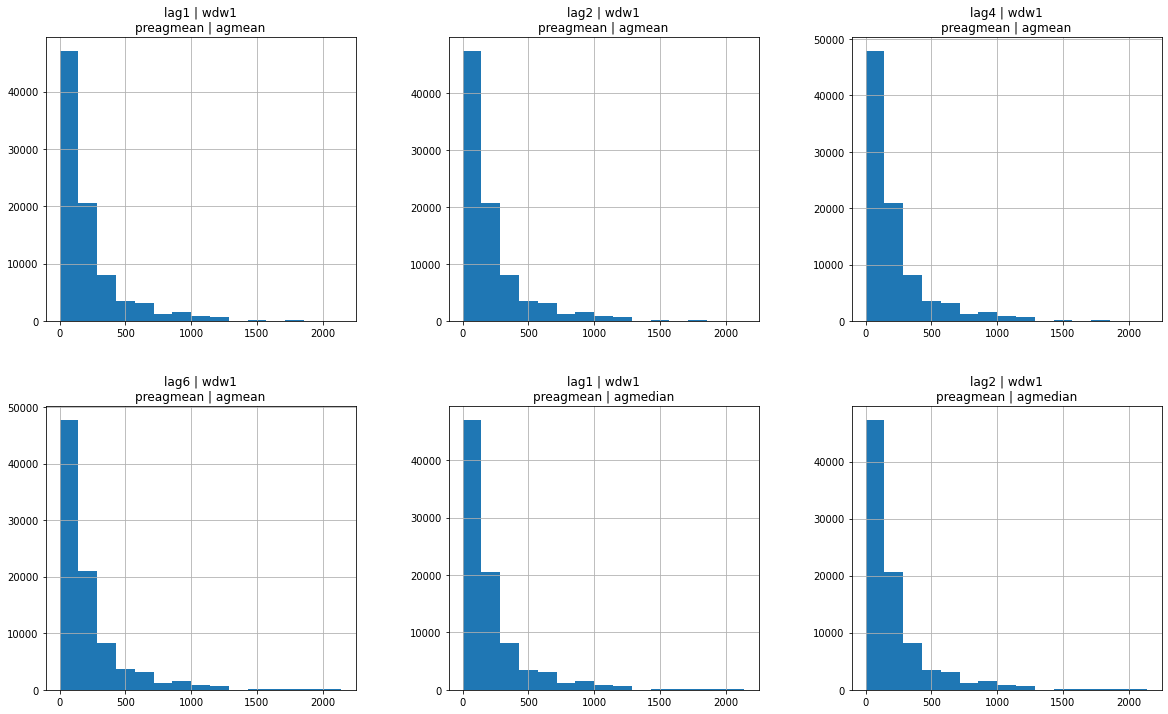

In [317]:
new_names = {}
for x in data_lagged_features.columns[11:17]:
    name = x.split('_')
    lag, w = name[0], name[1]
    preagr, agr = name[4], name[5]
    new_name = lag + ' | '+ w + '\n' +  preagr + ' | ' + agr
    new_names[x] = new_name


fig, ax = plt.subplots(2, 3, figsize = (20,12))
data_lagged_features[data_lagged_features.columns[11:17]].rename(columns=new_names).hist(ax=ax, bins=15)
plt.show()

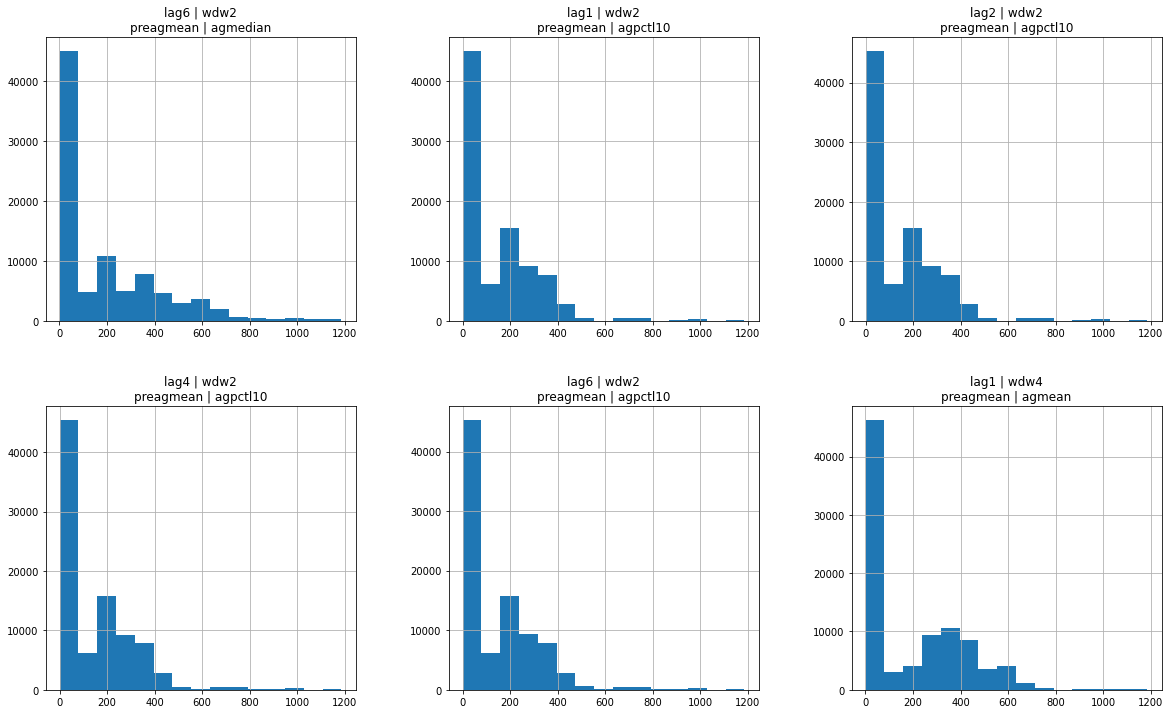

In [318]:
new_names = {}
for x in data_lagged_features.columns[30:36]:
    name = x.split('_')
    lag, w = name[0], name[1]
    preagr, agr = name[4], name[5]
    new_name = lag + ' | '+ w + '\n' +  preagr + ' | ' + agr
    new_names[x] = new_name


fig, ax = plt.subplots(2, 3, figsize = (20,12))
data_lagged_features[data_lagged_features.columns[30:36]].rename(columns=new_names).hist(ax=ax, bins=15)

plt.show()


# ROLLING МАЛЕНЬКОЕ ОКНО И ЛАГ

<AxesSubplot:title={'center':'Lag14Window14Mean'}, xlabel='Date'>

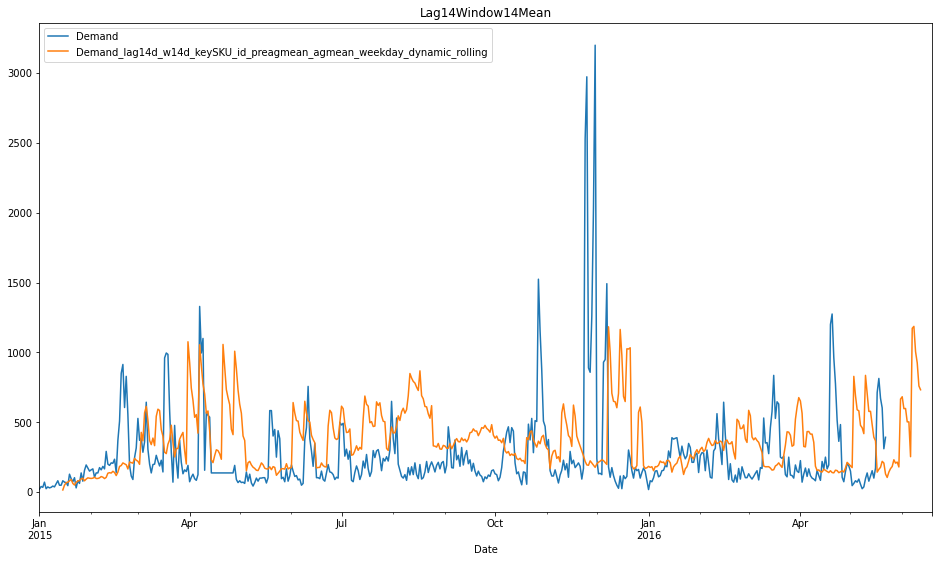

In [10]:
data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date')[['Demand', 'Demand_lag14d_w14d_keySKU_id_preagmean_agmean_weekday_dynamic_rolling']].plot(figsize=(16,9), title='Lag14Window14Mean')



<AxesSubplot:title={'center':'Lag14Window14Mean'}, xlabel='Date'>

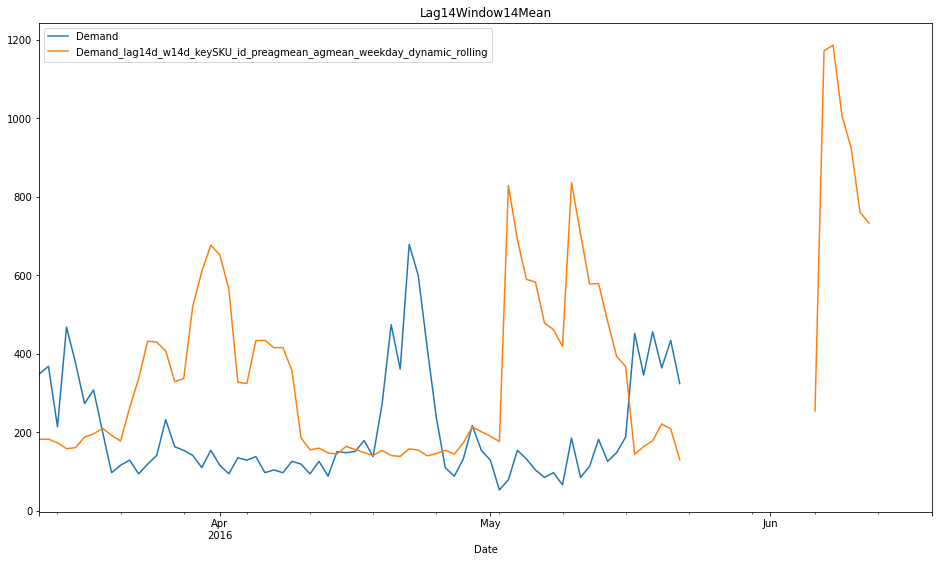

In [11]:
data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 10)].\
set_index('Date')[['Demand', 'Demand_lag14d_w14d_keySKU_id_preagmean_agmean_weekday_dynamic_rolling']].tail(100).plot(figsize=(16,9), title='Lag14Window14Mean')



# EWM МАЛЕНЬКОЕ ОКНО И ЛАГ

<AxesSubplot:title={'center':'Lag14Window14Mean'}, xlabel='Date'>

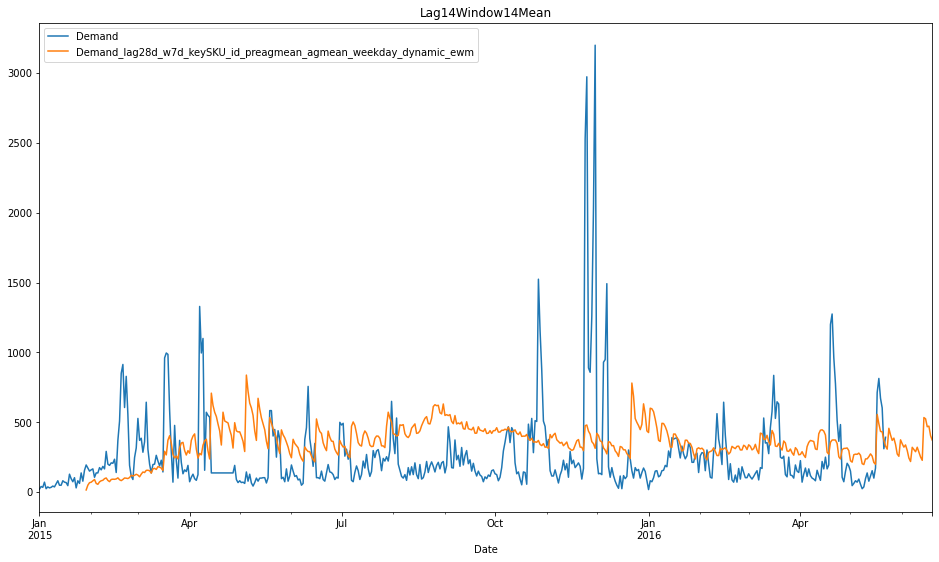

In [12]:
data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date')[['Demand', 'Demand_lag28d_w7d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm']].plot(figsize=(16,9), title='Lag14Window14Mean')



<AxesSubplot:title={'center':'Lag14Window14Mean'}, xlabel='Date'>

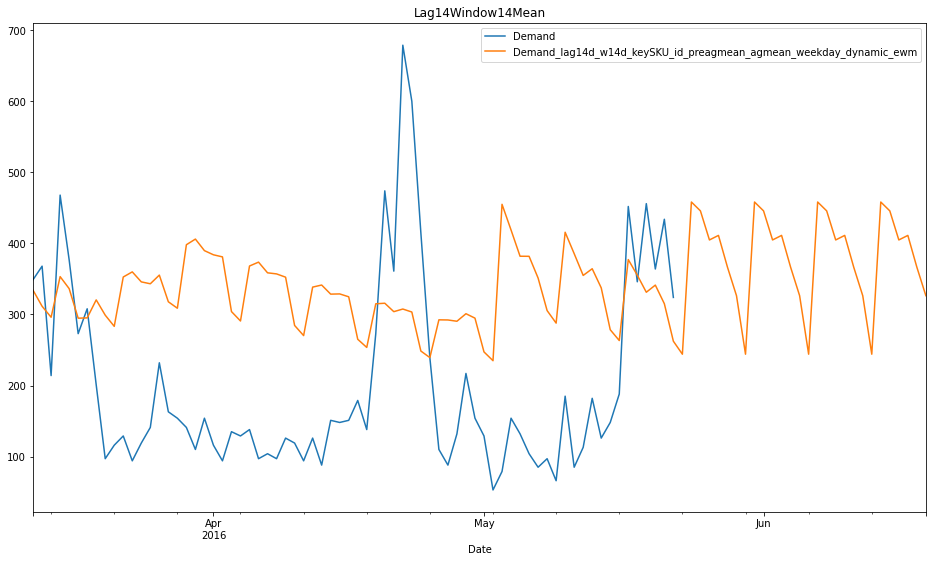

In [13]:
data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 10)].\
set_index('Date')[['Demand', 'Demand_lag14d_w14d_keySKU_id_preagmean_agmean_weekday_dynamic_ewm']].tail(100).plot(figsize=(16,9), title='Lag14Window14Mean')



# ROLLING БОЛЬШОЕ ОКНО И ЛАГ

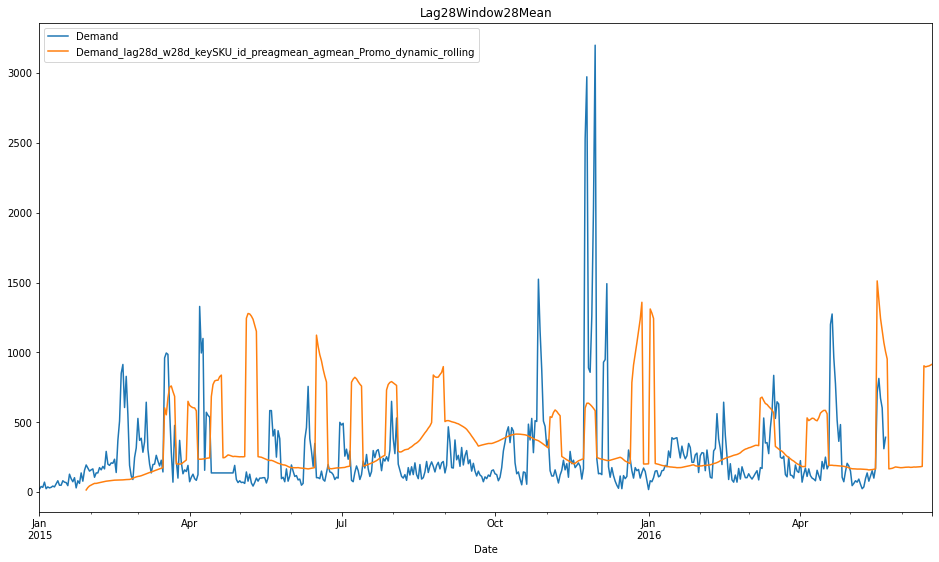

In [14]:
ax = data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date')[['Demand', 'Demand_lag28d_w28d_keySKU_id_preagmean_agmean_Promo_dynamic_rolling']].plot(figsize=(16,9), title='Lag28Window28Mean')


<AxesSubplot:title={'center':'Lag28Window28Mean'}, xlabel='Date'>

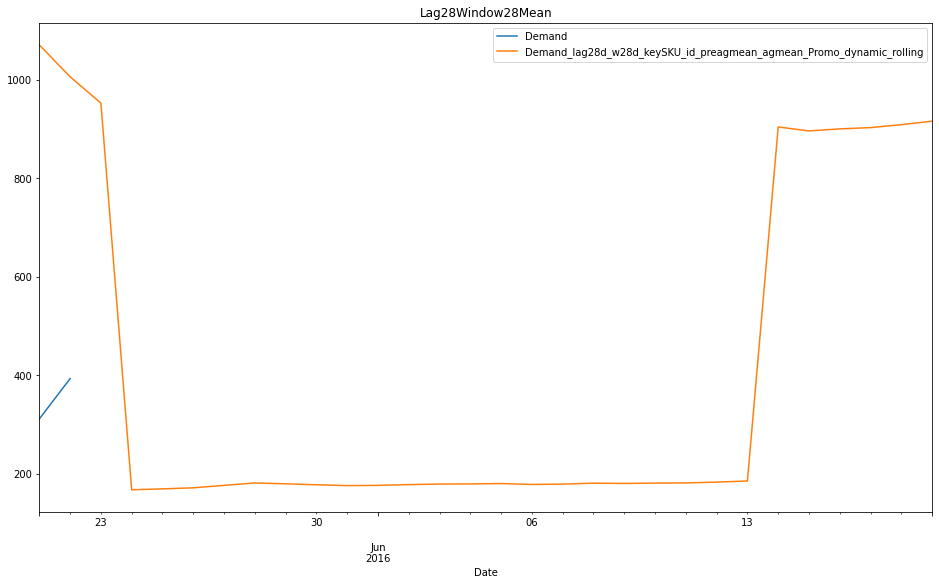

In [15]:
data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date')[['Demand', 'Demand_lag28d_w28d_keySKU_id_preagmean_agmean_Promo_dynamic_rolling']].tail(30).plot(figsize=(16,9), title='Lag28Window28Mean')



<AxesSubplot:title={'center':'Lag28Window28Mean'}, xlabel='Date', ylabel='Promo'>

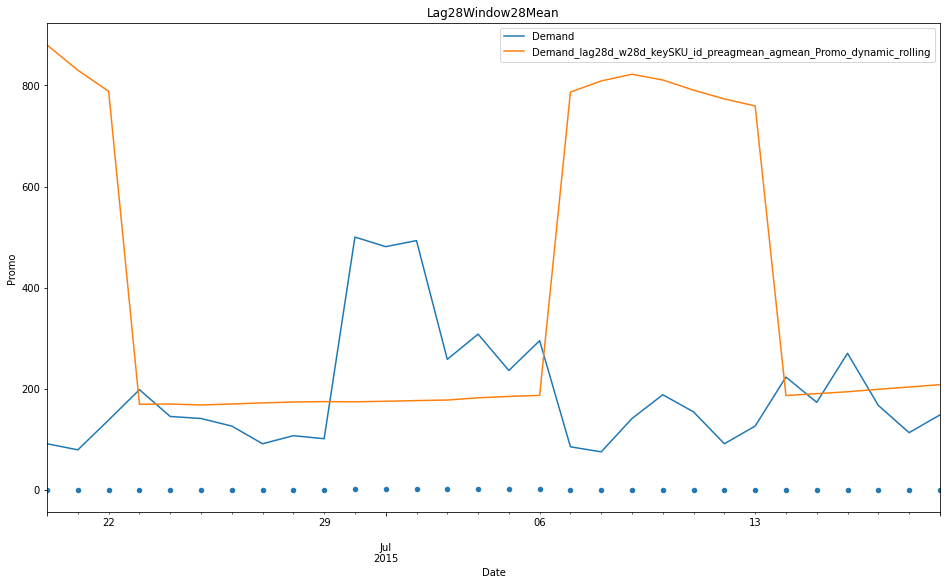

In [16]:
ax = data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date')[['Demand', 'Demand_lag28d_w28d_keySKU_id_preagmean_agmean_Promo_dynamic_rolling']].head(200).tail(30).plot(figsize=(16,9), title='Lag28Window28Mean')




data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date').reset_index().plot.scatter('Date', 'Promo', ax=ax)



<AxesSubplot:xlabel='Date', ylabel='Demand_lag28d_w7d_keySKU_id_preagmean_agmean_Promo_dynamic_rolling'>

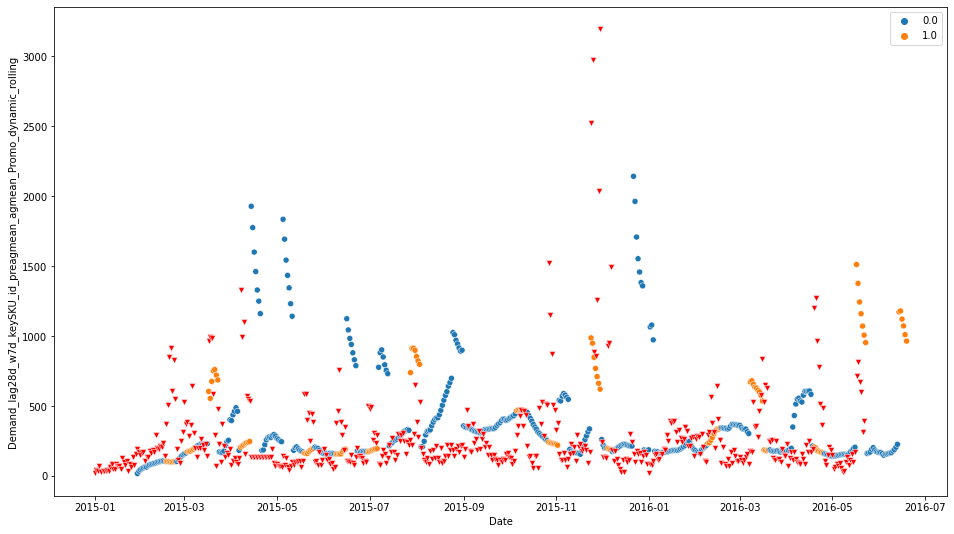

In [700]:
import seaborn as sns
plt.figure(figsize=(16, 9))
plotter =  data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date').sort_index().reset_index()
sns.scatterplot(data=plotter, x='Date', y='Demand_lag28d_w7d_keySKU_id_preagmean_agmean_Promo_dynamic_rolling', hue='Promo')
sns.scatterplot(data=plotter, x='Date', y='Demand', marker='v', color='r')

In [ ]:
data_lagged_features[(data_lagged_features['SKU_id'] == 1) & (data_lagged_features['Store_id'] == 1)].\
set_index('Date').reset_index().plot.scatter('Date', 'Promo', ax=ax)

# TO ANALYSE

In [90]:
df = deepcopy(data)
lf_df = df.set_index('Date').sort_index().groupby(['weekday', 'SKU_id'] + ['Date']).\
                            agg('mean').rolling(window=2, min_periods=1).agg('mean')


out_df = pd.merge(df, lf_df['Demand'].shift(2).reset_index().rename(columns = {'Demand': 'Rolled'}),
                                                  how='left', on=['SKU_id'] + ['Date'])

lf_df = df.set_index('Date').sort_index().groupby(['weekday', 'SKU_id'] + ['Date']).\
                            agg('mean').ewm(span=2, min_periods=1).agg('mean')


out_df = pd.merge(out_df, lf_df['Demand'].shift(2).reset_index().rename(columns = {'Demand': 'Rolled'}),
                                                  how='left', on=['SKU_id'] + ['Date'])


## Rolling лучше

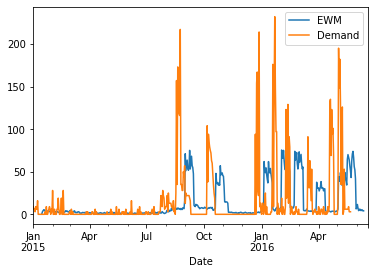

In [251]:
# out_df.set_index('Date', inplace=True)
out_df[(out_df['SKU_id'] == 2) & (out_df['Store_id'] == 1)]['Rolled_x'].plot(label='EWM')
out_df[(out_df['SKU_id'] == 2) & (out_df['Store_id'] == 1)]['Demand'].plot(label='Demand')
plt.legend()

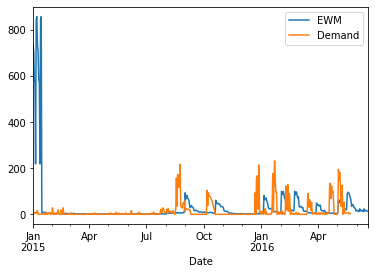

In [250]:
out_df[(out_df['SKU_id'] == 2) & (out_df['Store_id'] == 1)]['Rolled_y'].plot(label='EWM')
out_df[(out_df['SKU_id'] == 2) & (out_df['Store_id'] == 1)]['Demand'].plot(label='Demand')
plt.legend()

# EWM Лучше

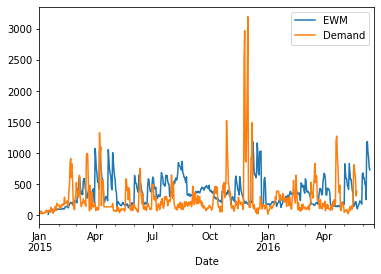

In [246]:
# out_df.set_index('Date', inplace=True)
out_df[(out_df['SKU_id'] == 1) & (out_df['Store_id'] == 1)]['Rolled_x'].plot(label='EWM')
out_df[(out_df['SKU_id'] == 1) & (out_df['Store_id'] == 1)]['Demand'].plot(label='Demand')
plt.legend()

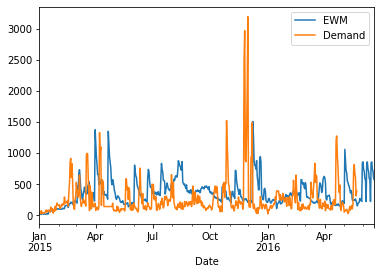

In [244]:
# out_df.set_index('Date', inplace=True)
out_df[(out_df['SKU_id'] == 1) & (out_df['Store_id'] == 1)]['Rolled_y'].plot(label='EWM')
out_df[(out_df['SKU_id'] == 1) & (out_df['Store_id'] == 1)]['Demand'].plot(label='Demand')
plt.legend()

In [325]:
# df.set_index('Date').sort_index().groupby(['SKU_id'] + ['Date']).head(1)

In [72]:
lf_df = df.set_index(['weekday', 'SKU_id', 'Date']).sort_index().groupby(level=['weekday', 'SKU_id', 'Date']).agg('mean').rolling(14, min_periods=1).mean()
out_df = pd.merge(df, lf_df['Demand'].shift(2).reset_index().rename(columns = {'Demand': 'Rolled'}),
                                                  how='left', on=['SKU_id'] + ['Date'])

# lf_df['Demand'].shift(2).reset_index()

In [326]:
# data[(data['weekday'] == 0)].groupby(['SKU_id', 'Date']).mean().rolling(2, min_periods=1).mean()['Demand']



In [96]:
## count - useless
## при использовании shift с фильтрами, lag и window должны указываться в неделях если говорим про фильтр weekday

## posssible structures: {'dynamic': {'filter_name': 'col_name'},
##                        'static': {'col_name': {'filter_name' :'condition'}}
##                       }


In [ ]:
## Преагрегация работает верно!
